<a href="https://colab.research.google.com/github/erikamoore/sam-i-am/blob/main/sam2_fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## this notebook builds off the following resources:
- [Meta AI – Segment Anything Model 2 (SAM2)](https://github.com/facebookresearch/segment-anything-2)  
- [Roboflow – SAM2 Video Segmentation Tutorial](https://github.com/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-videos-with-sam-2.ipynb)





---



## setup, imports, installs


In [1]:
IS_COLAB = True
import os
import sys

In [2]:
# ================== GPU diagnostic info ========================
!nvidia-smi
HOME = os.getcwd()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print("HOME:", HOME)

Mon May 12 06:02:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   33C    P8             16W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# ======================== installs ================================
!git clone https://github.com/facebookresearch/sam2.git
%cd {HOME}/sam2

# overwrite with modified file to limit caching (see issue #264)
!wget -O sam2/utils/misc.py https://raw.githubusercontent.com/erikamoore/sam-i-am/main/misc_v2.py

!pip install -e . -q
!python setup.py build_ext --inplace
!pip install -q supervision[assets] jupyter_bbox_widget

# model checkpoints (changed to be 2.1 models)
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2.1_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2.1_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt -P {HOME}/checkpoints


fatal: destination path 'sam2' already exists and is not an empty directory.
/content/sam2
--2025-05-12 06:02:42--  https://raw.githubusercontent.com/erikamoore/sam-i-am/main/misc_v2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10891 (11K) [text/plain]
Saving to: ‘sam2/utils/misc.py’

sam2/utils/misc.py  100%[===================>]  10.64K  --.-KB/s    in 0s      

2025-05-12 06:02:43 (128 MB/s) - ‘sam2/utils/misc.py’ saved [10891/10891]

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
running build_ext
/usr/local/lib/python3.11/dist-package

In [4]:
# ======================== general imports =============================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import base64
import supervision as sv
from pathlib import Path
from supervision.assets import download_assets, VideoAssets

# widget specific imports
if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

# more GPU setup
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
# ======================== helper functions =============================

# from meta's video notebook
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# from image notebook
def show_mask2(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# from meta's image notebook
def show_masks2(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask2(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

# for the displaying the widget
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [6]:
%pwd

'/content/sam2'

## model checkpoints and config

In [7]:
# ======================== SAM2 imports =============================
import sys
sys.path.append(f"{HOME}/sam2")

from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor

# CHECKPOINT = f"{HOME}/checkpoints/sam2.1_hiera_large.pt"
CHECKPOINT = f"{HOME}/checkpoints/sam2.1_hiera_base_plus.pt"
CONFIG = "configs/sam2.1/sam2.1_hiera_b+.yaml"


In [8]:
%cd ..

/content


## load video and split into frames

## make chunks

In [9]:
# path to our uploaded video
SOURCE_VIDEO = "3tiny_1m.mp4"
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

# scale the video for memory efficiency
SCALE_FACTOR = 0.6
START_IDX = 0
END_IDX = 1800
STRIDE = 600

# collecting all of the paths to our chunks so we can ref later
chunk_paths = []

# split source video frames in chunks and put in subfolders
SOURCE_CHUNKS = Path(HOME) / "chunks"
SOURCE_CHUNKS.mkdir(parents=True, exist_ok=True)

for i in range((END_IDX-START_IDX)//STRIDE):
  SOURCE_CHUNK = SOURCE_CHUNKS / f"chunk_{i}"

  # add to our list of chunk paths for later use
  chunk_paths.append(SOURCE_CHUNK)
  SOURCE_CHUNK.mkdir(parents=True, exist_ok=True)

  # if we are on chunk_0, we start on frame_0
  if i == 0:
    start = START_IDX

  # else break into chunks so that the last frame of the n th chunk
  # is the same as the first frame of the n+1 th chunk
  if i > 0:
    start = (i*STRIDE)-1

  end = (i+1)*STRIDE

  frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=start, end=end)
  images_sink = sv.ImageSink(
    target_dir_path=SOURCE_CHUNK.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg")


  with images_sink:
      for frame in frames_generator:
          frame = sv.scale_image(frame, SCALE_FACTOR)
          images_sink.save_image(frame)



## prompting on chunk_0

In [10]:
# path to our eventual chunk-specific output
chunk_name = chunk_paths[0].name
TARGET_VIDEO = Path(HOME) / f"{chunk_name}-out.mp4"

# SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_CHUNKS.as_posix(), extensions=["jpeg"]))
SOURCE_FRAME_PATHS = sorted(chunk_paths[0].glob("*.jpeg"))


In [11]:
# info about full video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info

VideoInfo(width=1440, height=1080, fps=30, total_frames=1817)

## set up predictor objects

In [12]:
# build an image predictor
sam2_model=build_sam2(CONFIG, CHECKPOINT, DEVICE)
ipredictor = SAM2ImagePredictor(sam2_model)


# separately, build a video predictor

# corrections didnt seem to work without this line
vpredictor = build_sam2_video_predictor(CONFIG, CHECKPOINT, DEVICE,
                                        non_overlap_masks=True,
                                        hydra_overrides_extra=
                                        ["++model.add_all_frames_to_correct_as_cond=True"])


# NEED TO CHANGE TO INIT ONLY ON THE START CHUNK
inference_state = vpredictor.init_state(video_path=chunk_paths[0].as_posix(),
                                         async_loading_frames=True,
                                         offload_video_to_cpu=True,
                                         offload_state_to_cpu=True)

# inference_state = vpredictor.init_state(video_path=SOURCE_FRAMES.as_posix(),
#                                         async_loading_frames=True,
#                                         offload_video_to_cpu=True,
#                                         offload_state_to_cpu=True)




using the modified misc file to load frames from disk and not cache.
using the modified misc file to load frames from disk and not cache.


In [53]:
#  ======================== reset predictors as needed =============================

# resets image predictor embeddings and state variables
ipredictor.reset_predictor()

# reset video predictor's inference state
vpredictor.reset_state(inference_state)

In [26]:
OBJECTS = ['obj1', 'obj2', 'obj3']

# create a unique integer label for each object
obj_to_ann_id = {obj: i for i, obj in enumerate(OBJECTS)}

In [27]:
# inference state has a built in so we dont actually need this
obj_to_ann_id

{'obj1': 0, 'obj2': 1, 'obj3': 2}

In [ ]:
# get widget
FRAME_IDX = 0
FRAME_PATH = SOURCE_CHUNKS/chunk_paths[0] / f"{FRAME_IDX:05d}.jpeg"

# FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

In [54]:
widget.bboxes

[{'x': 420, 'y': 455, 'width': 20, 'height': 28, 'label': 'obj1'},
 {'x': 559, 'y': 407, 'width': 27, 'height': 51, 'label': 'obj2'},
 {'x': 727, 'y': 442, 'width': 44, 'height': 17, 'label': 'obj3'}]

In [55]:
# prepare image predictor
IMAGE_PATH = FRAME_PATH
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
ipredictor.set_image(image_rgb)
print(ipredictor._features["image_embed"].shape, ipredictor._features["image_embed"][-1].shape)


torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [56]:
# maps obj id to a nested dict of frames of masks for that object
inference_state["mask_inputs_per_obj"]

{}

object label is obj1
box_arr is [[420 455 440 483]]
box_arr.shape is (1, 4)
processed obj1
masks.shape: (3, 648, 864), scores: [0.765625   0.7578125  0.73828125]


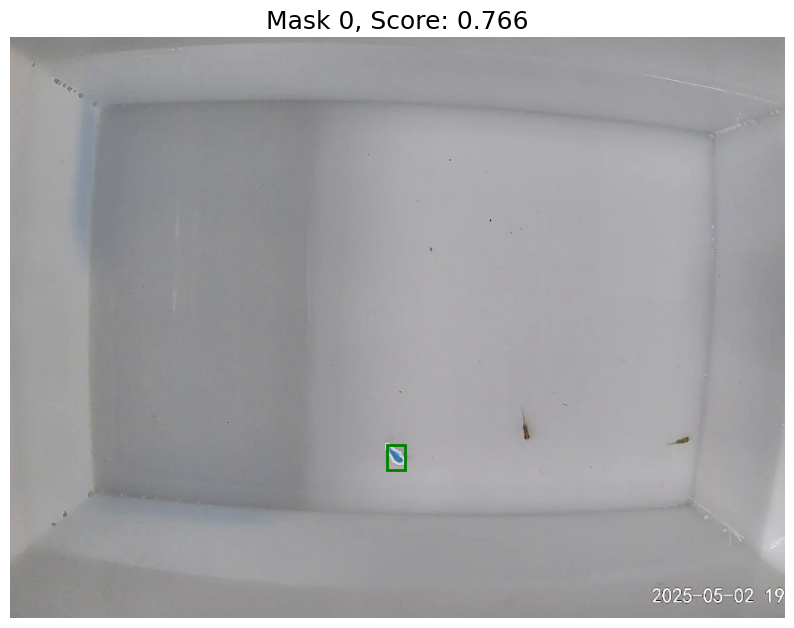

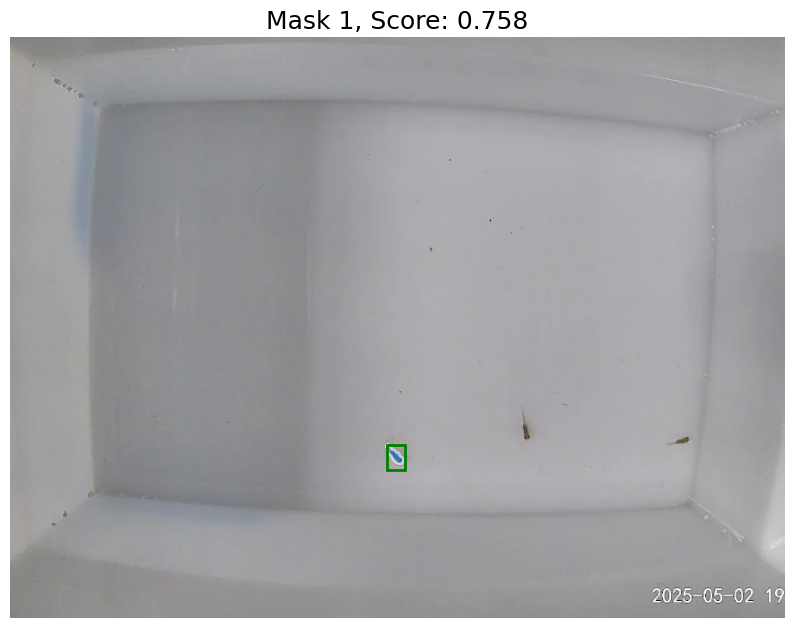

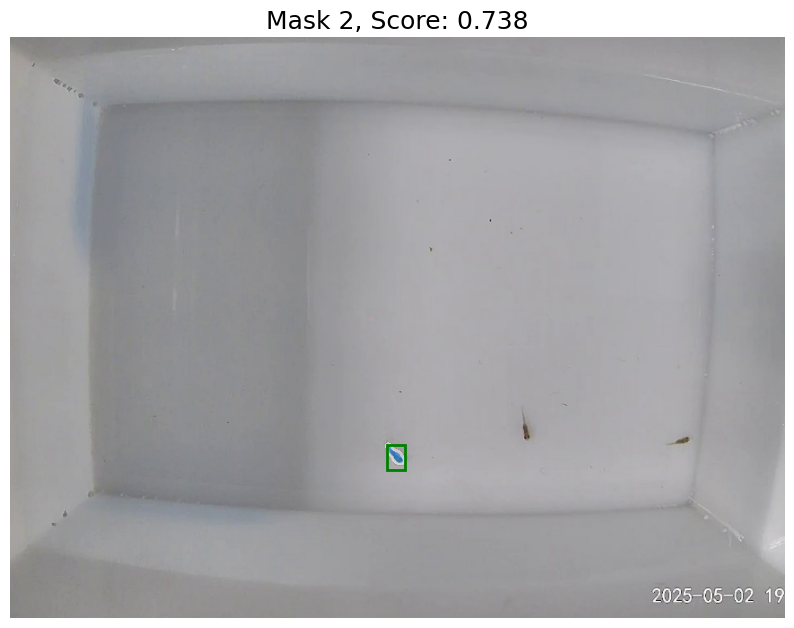


object label is obj2
box_arr is [[559 407 586 458]]
box_arr.shape is (1, 4)
processed obj2
masks.shape: (3, 648, 864), scores: [0.7265625  0.70703125 0.69140625]


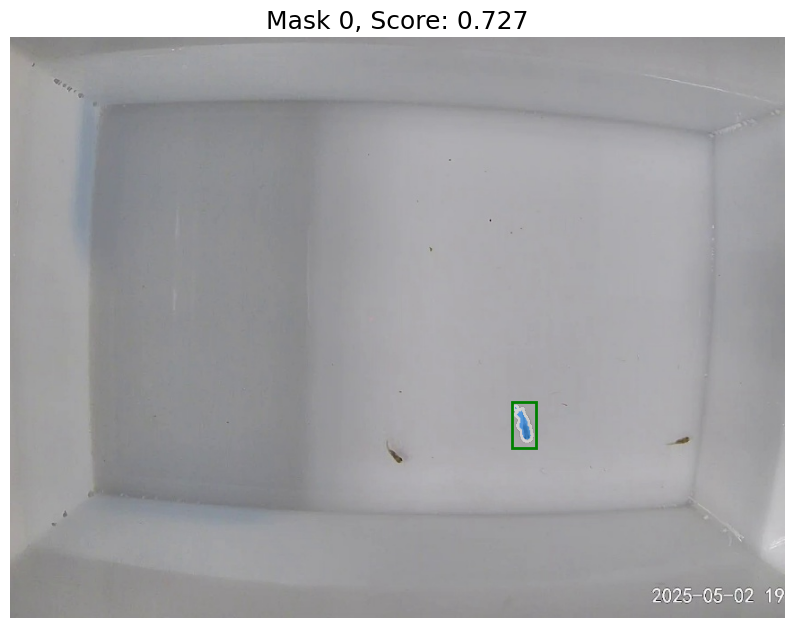

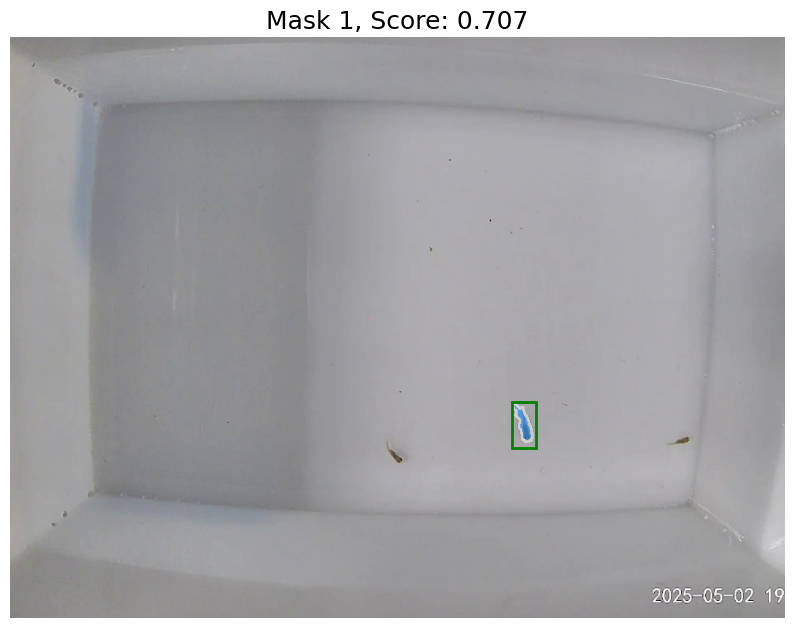

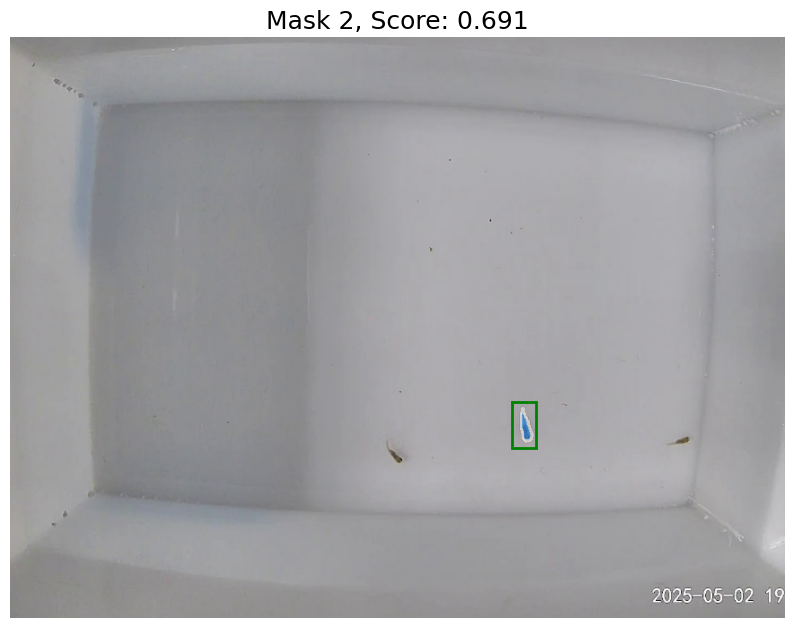


object label is obj3
box_arr is [[727 442 771 459]]
box_arr.shape is (1, 4)
processed obj3
masks.shape: (3, 648, 864), scores: [0.78515625 0.76171875 0.7578125 ]


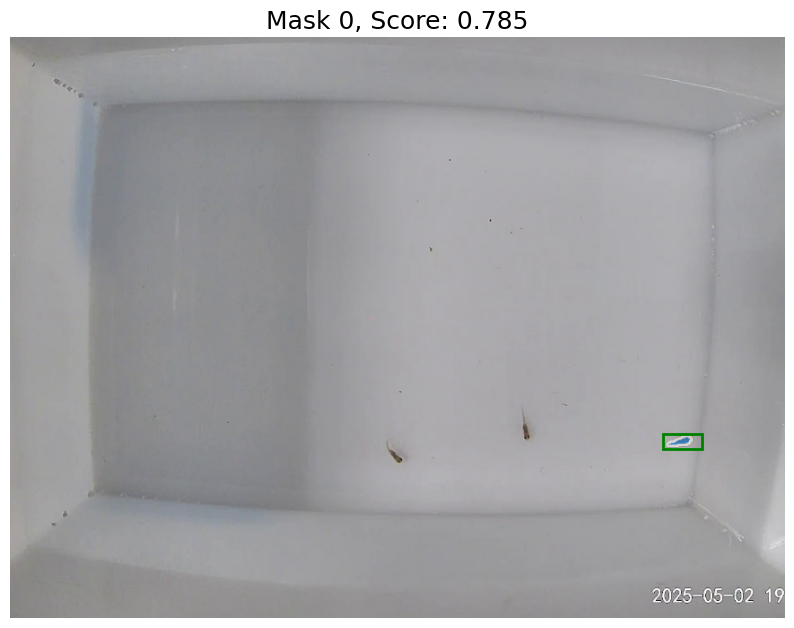

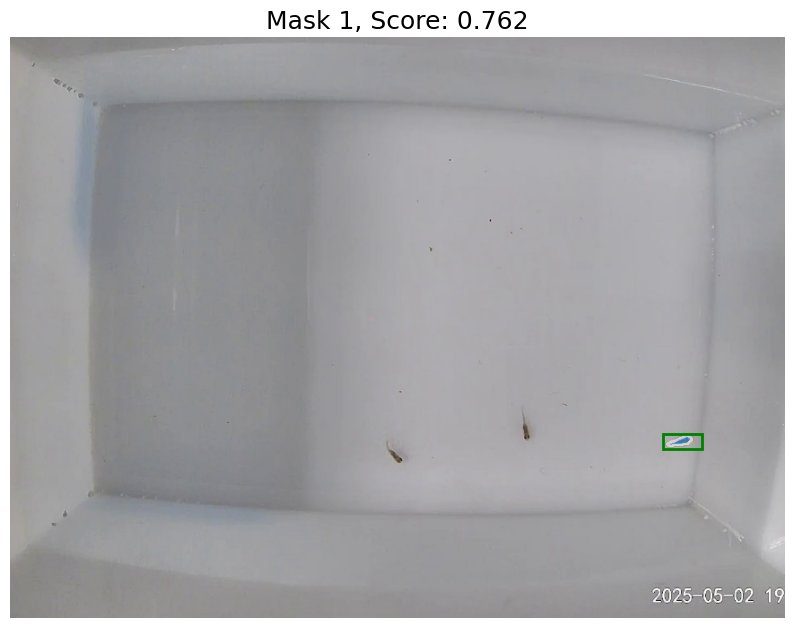

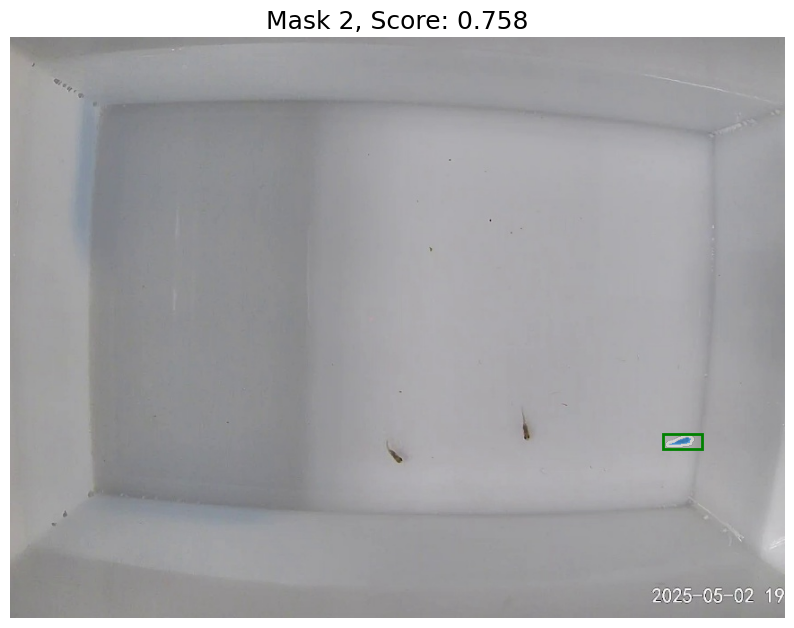


All predicted masks on this frame have been shown.


In [57]:
# just so the code doesn't break if we do not use widget
default_box = [{'x': 418, 'y': 453, 'width': 31, 'height': 36, 'label': 'obj1'},
 {'x': 569, 'y': 425, 'width': 14, 'height': 39, 'label': 'obj2'},
 {'x': 733, 'y': 441, 'width': 39, 'height': 19, 'label': 'obj3'}]

# get ipredictor masks for each bbox
all_ipreds = {}

# roboflow had a default box as backup
boxes = widget.bboxes if len(widget.bboxes) > 0 else default_box

for object_id, label in enumerate(OBJECTS):
    print(f"object label is {label}")
    box_list = [box for box in boxes if box['label'] == label]
    if len(box_list) == 0:
        continue

    # this was modified from the points array
    # check that this is the correct form. meta used dim (4,).
    box_arr = np.array([
            (box['x'],
            box['y'],
            box['x'] + box['width'],
            box['y'] + box['height'])
         for box in box_list
    ])

    input_box = np.squeeze(box_arr) if box_arr.shape[0] == 1 else box_arr
    print(f"box_arr is {box_arr}")
    print(f"box_arr.shape is {box_arr.shape}")

    input_label = np.array([1])

    # get 3 predictions back per object
    masks, scores, logits = ipredictor.predict(
        box=input_box,
        point_labels=input_label,
        multimask_output=True,
    )

    # sort in order of high score to low score
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]

    # store the predictions for each object
    all_ipreds[label] = {
        "masks": masks,
        "scores": scores,
        "logits": logits,
        "box": input_box,
    }
    print(f"processed {label}\nmasks.shape: {masks.shape}, scores: {scores}")


    show_masks2(image_rgb, masks, scores, box_coords=input_box, input_labels=input_label, borders=True)
    print()

print(f"All predicted masks on this frame have been shown.")

In [58]:
from pprint import pprint
print("all_ipreds looks like:")
pprint({k: {kk: vv.shape for kk, vv in v.items()} for k, v in all_ipreds.items()})

all_ipreds looks like:
{'obj1': {'box': (4,),
          'logits': (3, 256, 256),
          'masks': (3, 648, 864),
          'scores': (3,)},
 'obj2': {'box': (4,),
          'logits': (3, 256, 256),
          'masks': (3, 648, 864),
          'scores': (3,)},
 'obj3': {'box': (4,),
          'logits': (3, 256, 256),
          'masks': (3, 648, 864),
          'scores': (3,)}}


In [59]:
all_ipreds['obj1']

{'masks': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32),
 'scores': array([0.765625  , 0.7578125 , 0.73828125], dtype=float32),
 'logits': array([[[-19.25  , -19.    , -18.125 , ..., -16.875 , -19.125 ,
          -20.125 ],
         [-17.5   , -18.5   , -17.    

In [60]:
# FIX THIS WE NEED TO REDEFINE EACH TIME

# dict that maps each object id to the mask num (idx) we want to keep
mask_to_choice = {
    "obj1": 0,
    "obj2": 2,
    "obj3":0,
}


In [61]:
mask_to_choice

{'obj1': 0, 'obj2': 2, 'obj3': 0}

In [62]:
def choose_masks(all_ipreds, mask_to_choice):
  """ returns a dict containing best mask, scores, and logits for each object id """
  best_masks = {}

  for obj_id, mask_num in mask_to_choice.items():
    print(f"obj_id is {obj_id}")
    print(f"choosing mask_num {mask_num}\n")


    # choose the corresponding entries from all_ipreds
    best_masks[obj_id] = {
        "box": all_ipreds[obj_id]["box"],
        "logits": all_ipreds[obj_id]["logits"][mask_num],
        "mask": all_ipreds[obj_id]["masks"][mask_num],
        "score": all_ipreds[obj_id]["scores"][mask_num],
    }

  return best_masks



In [63]:
best_masks = choose_masks(all_ipreds, mask_to_choice)

obj_id is obj1
choosing mask_num 0

obj_id is obj2
choosing mask_num 2

obj_id is obj3
choosing mask_num 0



In [64]:
obj_to_ann_id

{'obj1': 0, 'obj2': 1, 'obj3': 2}

In [65]:
FRAME_IDX

0

In [66]:
# goal add each mask to the v predictor
for obj, mask_info in best_masks.items():
  # get the unique obj id integer
  ann_obj_id = obj_to_ann_id[obj]

  # get the mask we wanted for that obj
  mask_input = mask_info['mask']
  binary_mask = (mask_input > 0).astype(np.uint8)

  # pass the object's mask to the video predictor
  vpredictor.add_new_mask(inference_state, FRAME_IDX, ann_obj_id, binary_mask)



Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).


In [67]:
# prop_results = list(vpredictor.propagate_in_video(inference_state))

prop_results = list(vpredictor.propagate_in_video(inference_state))
# prop_results = list(vpredictor.propagate_in_video(inference_state, start_frame_idx=0, max_frame_num_to_track=300))

propagate in video: 100%|██████████| 600/600 [01:08<00:00,  8.70it/s]


In [68]:
# prepare for the propagation preview
# video_dir= "./3tiny_1m"
video_dir = chunk_paths[0]

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

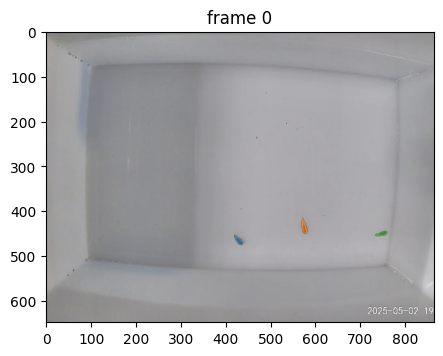

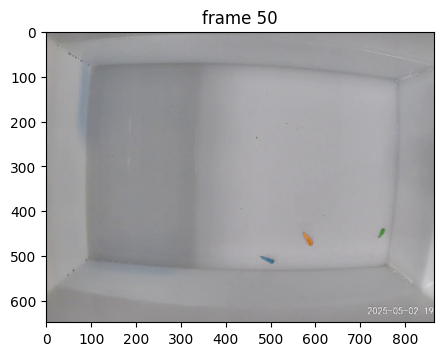

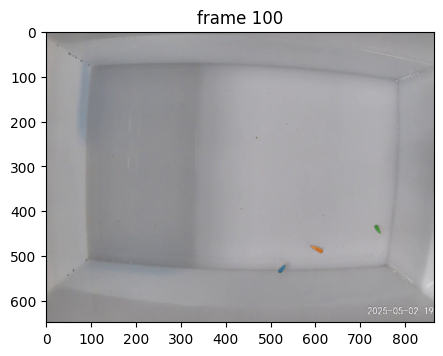

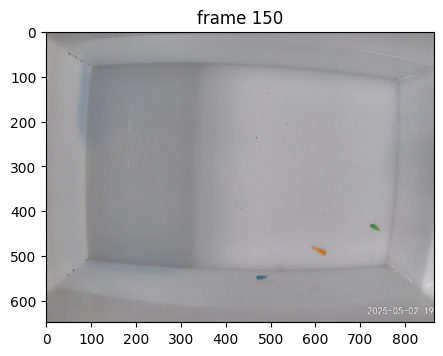

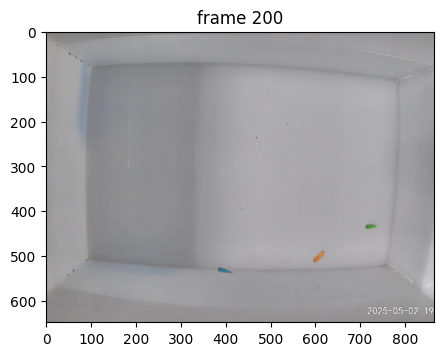

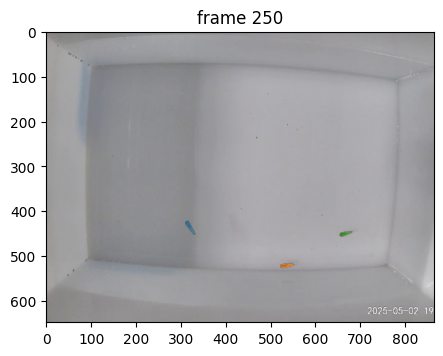

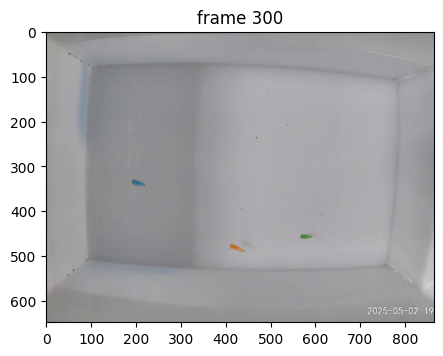

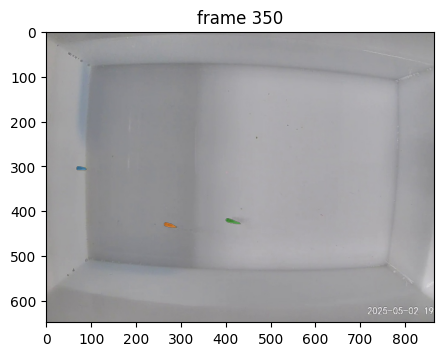

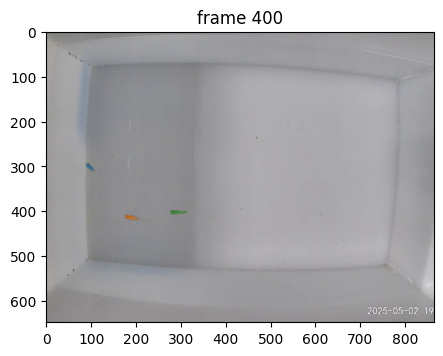

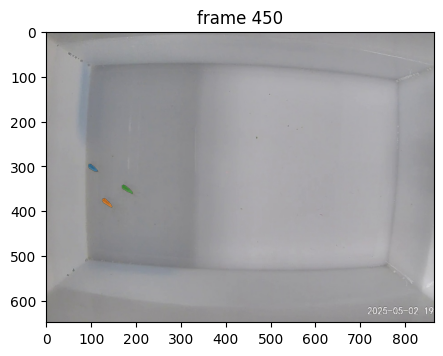

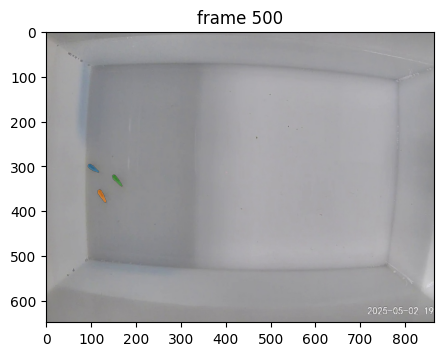

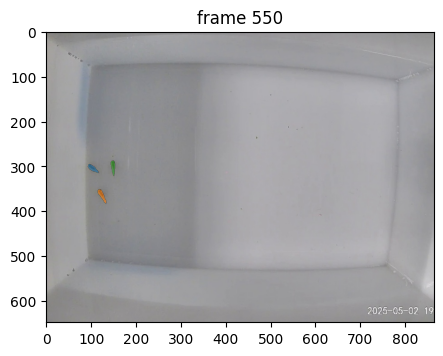

In [69]:
# collect the propagation results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results

# for out_frame_idx, out_obj_ids, out_mask_logits in vpredictor.propagate_in_video(inference_state):
for out_frame_idx, out_obj_ids, out_mask_logits in prop_results:

    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


# render the segmentation results every few frames
vis_frame_stride = 50
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(5, 5))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)


In [70]:
# testing rest of robo stuff to propagate...++++++++++++++++++++++

# test to make sure this works. i had to reload the video up above.
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

In [71]:

# this works like the robo version
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++

COLORS = ['#80ffff','#ff9933','#66ff66', '#990099', '#9933ff', '#ff66cc', '#0000ff']


mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, out_mask_logits in prop_results:
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)

        # this i kept the same
        out_mask_logits = (out_mask_logits>0.0).cpu().numpy()
        masks = (out_mask_logits > 0.0).astype(bool)

        # masks needs to be an array of shape (n, H, W)
        if masks.ndim == 4:
            masks = np.squeeze(masks, axis=1)  # remove the second dim

        if masks.ndim != 3:
            raise ValueError(f"Unexpected mask shape after processing: {masks.shape}")

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)


        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)


In [72]:
pprint({k: {kk: vv.shape for kk, vv in v.items()} for k, v in inference_state['mask_inputs_per_obj'].items()})

{0: {0: torch.Size([1, 1, 1024, 1024])},
 1: {0: torch.Size([1, 1, 1024, 1024])},
 2: {0: torch.Size([1, 1, 1024, 1024])}}


## once happy, write chunk_0 to disk to save RAM

In [73]:
# trying to save to disk
chunk_out = Path(HOME) / "chunk_results" / chunk_paths[0].name
chunk_out.mkdir(parents=True, exist_ok=True)

for out_frame_idx, out_obj_ids, out_mask_logits in prop_results:
    torch.save({"out_frame_idx": out_frame_idx,
                "out_obj_ids": out_obj_ids,
                "out_mask_logits": out_mask_logits.cpu(),},
                 chunk_out / f"{out_frame_idx:05d}.pt")

In [74]:
# since we've saved to disc we can now delete prop results
del prop_results
torch.cuda.empty_cache()

In [75]:
for chunk_idx, chunk_path in enumerate(chunk_paths[1:], 1):
    print(f"*"*50)
    print(f"processing {chunk_path}")
    print(f"chunk_idx is {chunk_idx}\n")

**************************************************
processing /content/chunks/chunk_1
chunk_idx is 1

**************************************************
processing /content/chunks/chunk_2
chunk_idx is 2



In [76]:
START_IDX

0

## repeat process for the remaining chunks

In [77]:
for chunk_idx, chunk_path in enumerate(chunk_paths[1:], 1):
    print(f"*"*50)
    print(f"processing {chunk_path}")
    print(f"chunk_idx is {chunk_idx}\n")

    # loading that last frame's info for our next chunk
    prev_chunk = Path(HOME)/"chunk_results"/chunk_paths[chunk_idx -1].name
    last_frame = sorted(prev_chunk.glob("*.pt"))[-1]
    last_data_out = torch.load(last_frame)
    last_logits_out = last_data_out['out_mask_logits']
    last_obj_ids_out = last_data_out['out_obj_ids']

    # add_new_mask expects 2 dimensional mask inputs so we remove that channel dim for each obj
    id_to_mask = {obj_id: (obj_logits > 0.0).squeeze(0) for obj_id, obj_logits in zip(last_obj_ids_out, last_logits_out)}

    # create a new inference state for the next chunk
    inference_state = vpredictor.init_state(video_path=chunk_paths[chunk_idx].as_posix(),
                                            async_loading_frames=True,
                                            offload_video_to_cpu=True,
                                            offload_state_to_cpu=True)


    # reset video predictor's inference state
    vpredictor.reset_state(inference_state)

    # goal add each mask to the v predictor
    for obj_id, mask in id_to_mask.items():
      # print(obj_id, mask.shape)
      # get the unique obj id integer
      # pass the object's mask to the video predictor
      vpredictor.add_new_mask(inference_state, 0, obj_id, mask)

    # propagate the masks for this new chunk
    # check if need to adjust max frame num to track
    prop_results = list(vpredictor.propagate_in_video(inference_state))


    # # prepare for the propagation preview
    # # video_dir= "./3tiny_1m"
    # video_dir = chunk_paths[chunk_idx]

    # # scan all the JPEG frame names in this directory
    # frame_names = [
    #     p for p in os.listdir(video_dir)
    #     if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    # ]
    # frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    # # collect the propagation results in a dict
    # video_segments = {}  # video_segments contains the per-frame segmentation results

    # # for out_frame_idx, out_obj_ids, out_mask_logits in vpredictor.propagate_in_video(inference_state):
    # for out_frame_idx, out_obj_ids, out_mask_logits in prop_results:

    #     video_segments[out_frame_idx] = {
    #         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
    #         for i, out_obj_id in enumerate(out_obj_ids)
    #     }

    # # OPTIONAL
    # # render the segmentation results every few frames
    # vis_frame_stride = 150
    # for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    #     plt.figure(figsize=(4, 4))
    #     plt.title(f"frame {out_frame_idx}")
    #     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    #     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
    #         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    # plt.show()

    # write chunk results to disk
    chunk_out = Path(HOME) / "chunk_results" / chunk_paths[chunk_idx].name
    chunk_out.mkdir(parents=True, exist_ok=True)

    for out_frame_idx, out_obj_ids, out_mask_logits in prop_results:
        torch.save({"out_frame_idx": out_frame_idx,
                    "out_obj_ids": out_obj_ids,
                    "out_mask_logits": out_mask_logits.cpu(),},
                    chunk_out / f"{out_frame_idx:05d}.pt")

    del prop_results
    torch.cuda.empty_cache()

**************************************************
processing /content/chunks/chunk_1
chunk_idx is 1

using the modified misc file to load frames from disk and not cache.
using the modified misc file to load frames from disk and not cache.


propagate in video: 100%|██████████| 601/601 [01:08<00:00,  8.77it/s]


**************************************************
processing /content/chunks/chunk_2
chunk_idx is 2

using the modified misc file to load frames from disk and not cache.
using the modified misc file to load frames from disk and not cache.


propagate in video: 100%|██████████| 601/601 [01:08<00:00,  8.77it/s]


## load each chunk from disk to render chunk vids

In [78]:
COLORS = ['#80ffff','#ff9933','#66ff66', '#990099', '#9933ff', '#ff66cc', '#0000ff']


mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

for chunk_idx, chunk_path in enumerate(chunk_paths):
  # print(f"chunk_path is {chunk_path}")
  chunk_res_path = Path(HOME)/"chunk_results"/chunk_path.name
  chunk_vid = Path(HOME) / f"{chunk_path.name}-out.mp4"

  # print(f"sorted_mask_files is {sorted_mask_files}")
  # find all files in the chunk_out_path and sort them by idx
  sorted_mask_info = sorted(chunk_res_path.glob("*.pt"))

  with sv.VideoSink(chunk_vid.as_posix(), video_info=video_info) as sink:
    # loading from disk
    for mask_file in sorted_mask_info:
      mask_info = torch.load(mask_file)
      frame_idx = mask_info['out_frame_idx']
      obj_ids = mask_info['out_obj_ids']
      out_mask_logits = mask_info['out_mask_logits']
      frame_path = chunk_path / f"{frame_idx:05d}.jpeg"
      # print(f"frame_path is {frame_path}")

      # ignore the duplicate we used for propagating across chunks
      if chunk_idx > 0 and frame_idx == 0:
        print(f"skipping frame {frame_idx} of chunk_{chunk_idx}")
        continue

      # this i kept the same as before
      frame = cv2.imread(str(frame_path))

      out_mask_logits = (out_mask_logits>0.0).cpu().numpy()
      masks = (out_mask_logits > 0.0).astype(bool)

      # masks needs to be an array of shape (n, H, W)
      if masks.ndim == 4:
          masks = np.squeeze(masks, axis=1)  # remove the second dim

      if masks.ndim != 3:
          raise ValueError(f"Unexpected mask shape after processing: {masks.shape}")

      detections = sv.Detections(
          xyxy=sv.mask_to_xyxy(masks=masks),
          mask=masks,
          class_id=np.array(obj_ids)
      )

      annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)


      sink.write_frame(annotated_frame)
      if frame_idx % video_info.fps == 0:
          frame_sample.append(annotated_frame)


skipping frame 0 of chunk_1
skipping frame 0 of chunk_2


In [ ]:
# after running on 1800 frames,
# 6.7/53 GB sys RAM used
# 6.3/22.5 GB GPU RAM used